# Esquemas numéricos para resolución de Ecuaciones Diferenciales Ordinarias

## Todo empieza por Euler. Aplicación al balance de un barco. 

En la clase teórica os presentamos una pequeña colección de métodos variopintos. Vamos a programar algunos de ellos para probarlos, pero primero empezaremos por el más sencillo: Euler. Abajo tenéis un ejemplo de implementación del esquema de Euler en Python: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sympy as sym
import time
import functools


# Tres cosas interesantes (contenido muy tecnico desde el punto de vista de la programacion):

# 1)
# Esta funcion se llama decorador. 
# Un decorador es una función que permite añadir funcionalidades a otra funcion,
# que queremos seguir llamando por su nombre, pero que queremos que haga
# alguna cosa extra aparte de las que ya hace. En este caso, la "cosa extra" 
# es imprimir su tiempo de ejecucion.
def timer(func):
    
    # Obtenemos los argumentos de la funcion func y sus valores
    # ! Que casualdiad que la funcion wraps es un decorador tambien !
    # ESto nos sirve para ver como se decora una funcion:
    @functools.wraps(func)
    
    # Definimos una función nueva que hace lo mismo que func
    # y la "cosa extra"
    def medir_tiempo(*args, **kwargs):
        start_time = time.perf_counter()     
        resultado  = func(*args, **kwargs)
        end_time   = time.perf_counter()
        run_time   = end_time - start_time
        
        print(f" Función {func.__name__!r} ejecutada en {run_time:.4f} secs")
        return resultado
    
    # Devolvemos la nueva función decorada
    return medir_tiempo


# 2) Prepararse una funcion para hacer plots. Fijaos que tiene varios detalles interesantes.
# Podeis variarla como querais
def plotear(x, y):
    """Plot a vector or set of vectors in a cool manner
    
    Parameters:
    x : Could be either:
        a) a numpy array containing grid for x axis
        b) a list of numpy arrays. In this case, y has to be an array
        as well, and they must have the same length.
    y : Could be either:
        a) a nunmpy array containing values for the y axis
        b) a list of numpy arrays containing several sets of elements

    Returns:
    None.
    """
    plt.figure(figsize=(9,6))
    plt.grid()
    
    color = iter(['b-', 'r-', 'g-', 'c-', 'k-', 'y-'])
    
    # Check if y contains several arrays:
    if type(x) is list and type(y) is list:
        for ii in range(len(x)):
            plt.plot(x[ii], y[ii], next(color))
    elif type(y) is list:
        for yy in y:
            plt.plot(x, yy, next(color))
    else:
        plt.plot(x, y)

    plt.show() 
    return None 

# 3) 
# Además, fíjate en el uso de las funciones lambda dentro de la funcion imp_ODEsolv, mas abajo,
# Las funciones lambda son muy utiles para cosas como esta. Os animo a que aprendais un poco sobre ellas./

def quaderr(u, v, h):
    return np.sqrt(np.sum(np.square(u - v)) * h)

In [2]:
def euler(f, tn, yn, h):
    return yn + h * f(tn, yn)

@timer # Así decoramos la función !
def exp_ODEsolv(f, t_0, t_f, N, y0, method="euler"):
    
    # Definimos el paso de malla en función del núero de nodos que nos piden:
    h = (t_f - t_0)/int(N)
    t = np.linspace(t_0, t_f, N)
    Y = np.zeros((N, len(y0))) # Construimos un array para 
    
    # Imponemos la condicion inicial
    Y[0,:] = y0
    
    if method == "euler":
        for n in range(0,N-1):
            Y[n+1,:] = euler(f, t[n], Y[n,:], h)
            
    # Podemos ir añadiendo mas metodos aqui
    else: 
        print("Error ! no conozco el metodo ", method)
        
    return Y

Fijáos en que está programado de una forma curiosa, porque está implementado en dos funciones, de manera que una llama a la otra. Luego entenderemos la utilidad de ésto.

Apliquemos este esquema a un ejemplo. Consideremos la siguiente ecaución linearizada de un ensayo de extinción del balance ("roll decay test") de un barco o de un artefacto flotante cualquiera: 
$$
\theta^{\prime \prime} + 2 \xi \omega_0 \theta^{\prime} + \omega_0^2 \theta = 0,
$$

donde $\xi$ es un porcentaje del amortiguamiento crítico, y $\omega_0$ es la frecuencia natural de balance del barco. Como veis, es simplemente la ecuación de un péndulo amortiguado. La solución general del sistema se puede obtener analíticamente, en este caso:
$$
\theta = \theta_0 e^{(-\xi \omega_0 t)} (\cos(\omega_0 t) + \xi \sin(\omega_0 t)).
$$

Recordad que para resolver ecuaciones de orden superior, debemos transformar la ecuación en un sistema de ecuaciones de orden uno. Llamaremos $x = \theta$ e $y = \theta^{\prime} = x^{\prime}$. Con ello se tiene:


$$ 
\left\{
\begin{array}{ll}
      x^{\prime} = y, \\
      y^{\prime} = -2 \xi \omega_0 y -\omega_0^2 x. \\
\end{array} 
\right.
$$

Vamos a pintar ahora la solución exacta a ver qué pinta tiene:

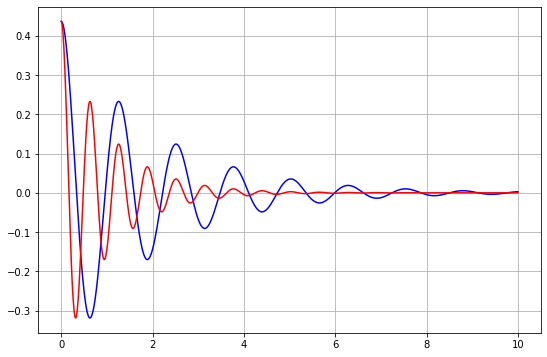

In [3]:
omega_0 = 5. 
xi      = .1
theta_0 = 25. * np.pi / 180

# La solución exacta:
def decay(t, om0=omega_0, xi=xi, th0=theta_0):
    return th0 * np.exp(-xi * om0 * t) * (np.cos(om0 * t) + xi * np.sin(om0 * t))

t = np.linspace(0, 10, 1000)
plotear(t, [decay(t), decay(t,10,0.1)])

Hay en este pedazo de código varios detalles de programación interesantes. Para los que les guste programar (no se pedirá para evaluación):
- Fijáos en la función "plotear", que contiene varias cosas interesantes. Una de ellas es la manera de comprobar si la variable "y" es una lista o no. Muy intuitiva la sintaxis, ¿Verdad?
- Otro detalle es el uso de las funciones "iter" y "next". Básicamente, la función iter convierte la lsita en un "objeto iterable", que es como una especie de lista pero "tuneada", vamos que almacena por ahí un índice y se acuerda de que posición marcaba dicho índice antes (¡porque lo tiene guardado!) y podemos pedirle que nos de el siguiente. Lo que, como véis en este ejemplo, puede ser muy cómodo. 
- Además, fijáos en que la función "decay" contiene parámetros con valores por defecto (eso ya sabemos lo que es), pero fijáos que algunos pueden tener el mismo nombre que variables definidas antes, como "xi$=$xi", y a python no le molesta, pero hay que tener presente que son dos variables diferentes.
- En esta línea, más abajo, fijáos que la función f_1 que define el sistema de ecuaciones de orden uno que vamos a resolver. Utiliza variables que están definidas antes (xi y omega_0), y Python, que es muy dócil, no se queja. Esto es una manera de hacer las cosas interesante de Python, pero hay que ser consciente de ello, porque en otros lenguajes no es así, y las funciones no funcionarían definidas de ese modo. 

Bueno, vamos ahora con el Euler. Primero voy a obtener una condición inicial para la velocidad angular, de manera que mi solución numérica aproxime exactamente la azul de arriba. Usaremos cálculo simbólico:

In [4]:
ts, ths, xis, oms = sym.symbols('t theta_0 xi omega_0')
fs   = ths * sym.exp(-xis * oms * ts) * (sym.cos(oms) + xis * sym.sin(oms * ts))

# Obtenemos la derivadas:
fps  = sym.diff(fs, ts)

# Las evaluamos en t=0:
fps.subs(ts, 0.)

-omega_0*theta_0*xi*cos(omega_0) + omega_0*theta_0*xi

In [5]:
# Y calculamos asi las condiciones iniciales:
yp0  = omega_0 * theta_0 * xi * (np.cos(omega_0) - 1.)
print(yp0)

-0.15628066775259003


 Función 'exp_ODEsolv' ejecutada en 0.0147 secs


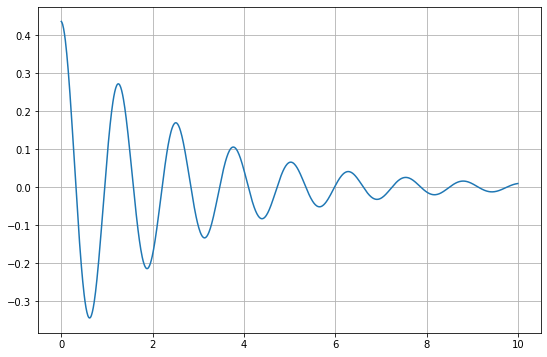

In [6]:
# Definimos la funcion que determina el sistema:
def f_1(t, Y):
    return np.array([Y[1], -2. * xi * omega_0 * Y[1] - omega_0*omega_0 * Y[0]])

# Resolvemos usando nuestro algoritmo:
t0 = 0.
tf = 10.
Nt = 1000 # Probar con 3000
Y = exp_ODEsolv(f_1, t0, tf, Nt, np.array([theta_0, yp0]))
plotear(np.linspace(t0, tf, Nt), Y[:,0])

## Y también... ¡Euler implícito!

Vamos a ver ahora como implementar método implícitos. Para ello, vamos a utlizar la misma estrategia de antes, con dos funciones para implementar el método. Veamos el ejemplo más simple, **Euler implícito**:

In [7]:
def imp_euler(ynp1, f, tn, yn, h):
    return yn + h * f(tn, ynp1)

@timer
def imp_ODEsolv(f, t_0, t_f, N, y0, method="euler"):
    
    # Definimos el paso de malla en función del núero de nodos que nos piden:
    h = (t_f - t_0)/int(N)
    t = np.linspace(t_0, t_f, N)
    Y = np.zeros((N, len(y0))) # Construimos un array para 
    
    # Imponemos la condicion inicial
    Y[0,:] = y0
    
    if method == "euler":
        for n in range(0,N-1):
            # Normalmento no se hace así por se poco eficiete, sino que se utiliza 
            # la estrategia predictor-corrector:
            Y[n+1,:] = opt.root(lambda x : x - imp_euler(x, f, t[n], Y[n,:], h), x0=Y[n,:]).x
            
    # Podemos ir añadiendo mas metodos aqui
    else: 
        print("Error ! no conozco el metodo ", method)
        
    return Y

 Función 'imp_ODEsolv' ejecutada en 0.2804 secs


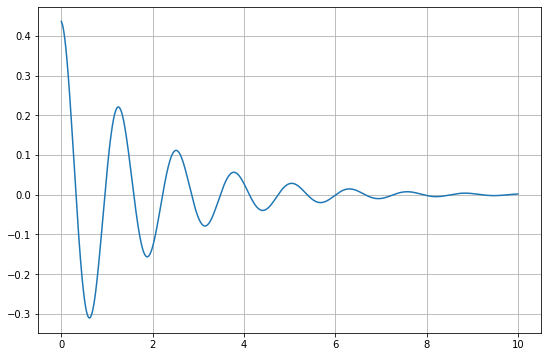

In [8]:
Nt2   = 3000
imp_Y = imp_ODEsolv(f_1, t0, tf, Nt2, np.array([theta_0, yp0]))
plotear(np.linspace(t0, tf, Nt2), imp_Y[:,0])

Y ahora comparamos todos ambos métodos (explítito e implícito) conla solución exacta:

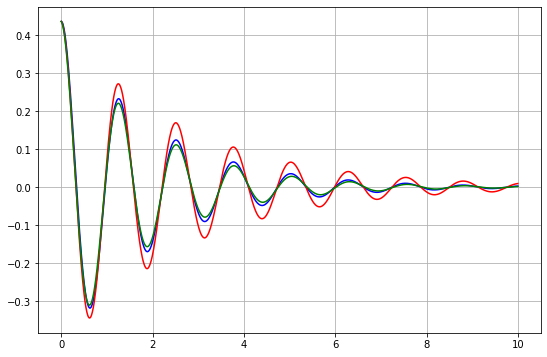

In [9]:
plotear([t, np.linspace(t0, tf, Nt), np.linspace(t0, tf, Nt2)], [decay(t), Y[:,0], imp_Y[:,0]])

### Ejercicio 1

Obtén el orden de convergencia de los métodos de Euler explícito e implícito. Recuerda que el orden de convergencia, $\gamma$, lo obtenemos a partir de la siguiente expresión:
$$
\dfrac{e_{n+1}}{e_n^{\gamma}} \longrightarrow K,
$$
para una cierta constante, $K$. Pero ojo a lo que llamamos $e_n$. Recordemos que cuando hablábamos de aproximación de raíces, los errores eran las diferencias de las soluciones que ibamos oteniendo respecto a la solución anterior. Las soluciones en ese caso son puntos, escalares, un número real... Aquí no. Aquí la solución es una aproximación discreta de una función, por lo que los errores deberán calcularse utilizando algún tipo de medida (¡o norma! La norma es un término matemático, más técnico) vectorial. 

En este contexto de las ODE's, definiremos el error como el error cuadrático de la diferencia entre la solución numérica y la solución exacta evaluada en la malla. El error cuadrático lo definiremos esta vez como:
$$
E(u, v, h) = \sqrt{\sum_{k=0}^{N-1}(u_k - v_k)^2) h}
$$

Orden de convergencia Euler implicito:
 Función 'imp_ODEsolv' ejecutada en 0.1179 secs
 Función 'imp_ODEsolv' ejecutada en 0.0900 secs
0.8252488600008404
 Función 'imp_ODEsolv' ejecutada en 0.1331 secs
0.8471048962382677
 Función 'imp_ODEsolv' ejecutada en 0.2830 secs
0.8897577769901751
 Función 'imp_ODEsolv' ejecutada en 0.5898 secs
0.9433040312955837
 Función 'imp_ODEsolv' ejecutada en 1.1106 secs
0.980139029347299
 Función 'imp_ODEsolv' ejecutada en 2.1294 secs
0.9946154674228691
 Función 'imp_ODEsolv' ejecutada en 4.2648 secs
0.9987432114824853
 Función 'imp_ODEsolv' ejecutada en 8.5580 secs
0.9997565716375723
 Función 'imp_ODEsolv' ejecutada en 17.0027 secs
0.9999766805358757
Orden de convergencia Euler Explicito:
0.5632797711377415
0.757001053719917
0.853684640653332
0.9310213205676278
0.9771923620606076
0.9939180695300877
0.9985050599960281
0.9996491464633855
0.9999236830687543


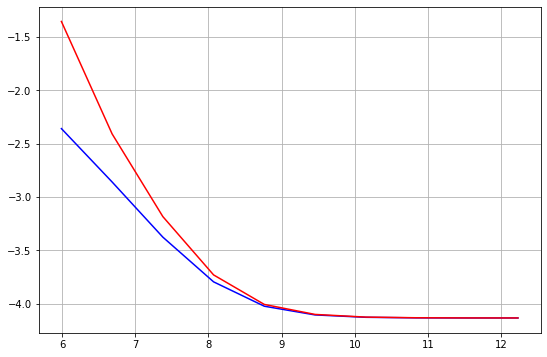

In [17]:
nn = 100 * 2**np.arange(2,12,1)

imp_err = []
exp_err = []

#implicito_old = imp_ODEsolv(f_1, t0, tf, 200, np.array([theta_0, yp0]))

# Implicito:
print("Orden de convergencia Euler implicito:")
for jj,n in enumerate(nn):
    implicito = imp_ODEsolv(f_1, t0, tf, n, np.array([theta_0, yp0]))
    imp_err.append(quaderr(implicito[:,0], decay(np.linspace(t0, tf, n)), (tf-t0)/n))
 #   imp_err.append(quaderr(implicito[:,0], implicito_old[:,0]))
 #   implicito_old = implicito
    if (jj):
        print(np.log(imp_err[-2])/np.log(imp_err[-1]))

# Explicito:
print("Orden de convergencia Euler Explicito:")
for jj,n in enumerate(nn):
    explicito = exp_ODEsolv(f_1, t0, tf, n, np.array([theta_0, yp0]))
    exp_err.append(quaderr(explicito[:,0], decay(np.linspace(t0, tf, n)), (tf-t0)/n))

    if (jj):
        print(np.log(exp_err[-2])/np.log(exp_err[-1]))

        
imp_err = np.array(imp_err)
exp_err = np.array(exp_err)

plotear(np.log(nn), [np.log(imp_err), np.log(exp_err)])

## Otros métodos implícitos

### Ejercicio 2 

Ahora, dentro del esquema anterior, implementad vosotros los métodos correspondientes a los siguientes esquemas implícitos vistos en clase:

- **Método del trapecio**:

$$
y_{n+1} = y_n + \dfrac{h}{2} \big(f_n + f_{n+1} \big).
$$

- **Método de Heun**:
$$
y_{n+1} = y_n + \dfrac{h}{2} \big( f_{n} + f\big(t_{n+1}, y_n + h f_n \big)\big).
$$

Se ha notado $f_j = f(t_j, y_j)$

### Ejercicio 3

Aplicadlos a la ecaución del decay de balance. 

In [11]:
# Trapecio:
def imp_trapecio(ynp1, f, tn, yn, h):
    return yn + .5 * h *(f(tn, yn) + f(tn + h, ynp1))

# Heun:
def imp_heun(ynp1, f, tn, yn, h):
    fn = f(tn, yn)
    return yn + .5 * h * (fn + f(tn + h, yn + h * fn))

# Actualizamos ahora nuestra función:
@timer
def imp_ODEsolv(f, t_0, t_f, N, y0, method="euler"):
    
    # Definimos el paso de malla en función del núero de nodos que nos piden:
    h = (t_f - t_0)/int(N)
    t = np.linspace(t_0, t_f, N)
    Y = np.zeros((N, len(y0))) # Construimos un array para 
    
    # Imponemos la condicion inicial
    Y[0,:] = y0
    
    if method == "euler":
        for n in range(0,N-1):
            # Normalmento no se hace así por se poco eficiete, sino que se utiliza 
            # la estrategia predictor-corrector:
            Y[n+1,:] = opt.root(lambda x : x - imp_euler(x, f, t[n], Y[n,:], h), x0=Y[n,:]).x
    elif method == "trapecio":
        for n in range(0,N-1):
            # Normalmento no se hace así por se poco eficiete, sino que se utiliza 
            # la estrategia predictor-corrector:
            Y[n+1,:] = opt.root(lambda x : x - imp_trapecio(x, f, t[n], Y[n,:], h), x0=Y[n,:]).x
    elif method == "heun":
        for n in range(0,N-1):
            # Normalmento no se hace así por se poco eficiete, sino que se utiliza 
            # la estrategia predictor-corrector:
            Y[n+1,:] = opt.root(lambda x : x - imp_heun(x, f, t[n], Y[n,:], h), x0=Y[n,:]).x
            
    # Pregunta: ? Por que no hago el if dentro del bucle?
    # Podemos ir añadiendo mas metodos aqui
    else: 
        print("Error ! no conozco el metodo ", method)
        
    return Y

 Función 'exp_ODEsolv' ejecutada en 0.0163 secs
 Función 'imp_ODEsolv' ejecutada en 0.1597 secs
 Función 'imp_ODEsolv' ejecutada en 0.1343 secs
 Función 'imp_ODEsolv' ejecutada en 0.1590 secs


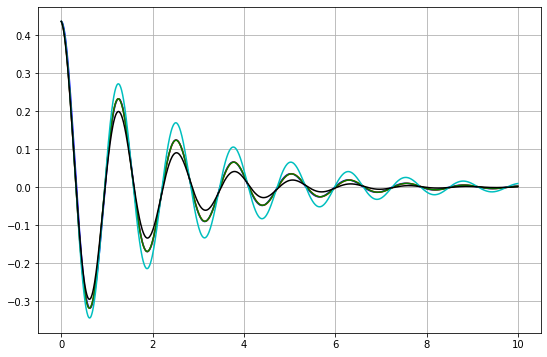

In [12]:
# Los probamos!
Nt2 = 1000
Y_euex = exp_ODEsolv(f_1, t0, tf, Nt2, np.array([theta_0, yp0]))
Y_euim = imp_ODEsolv(f_1, t0, tf, Nt2, np.array([theta_0, yp0]))
Y_trap = imp_ODEsolv(f_1, t0, tf, Nt2, np.array([theta_0, yp0]), method="trapecio")
Y_heun = imp_ODEsolv(f_1, t0, tf, Nt2, np.array([theta_0, yp0]), method="heun")
t2 = np.linspace(t0, tf, Nt2)
plotear(t2, [decay(t2), Y_trap[:,0], Y_heun[:,0], Y_euex[:,0], Y_euim[:,0]])

## Métodos semi-implícitos o de tipo predictor-corrector

El problema con esta estrategia que nos hemos planteado a la hora de resolver los métodos implícitos es que es muy ineficiente, porque en cada paso de tiempo tenemos que resolver un problema de búsqueda de raíces que ya de por sí es costoso, como para querer resolverlo en cada paso de tiempo. Como prueba de esto, podéis calcular los tiempos de ejecución del ejemplo del decay para 10000 nodos con cada uno de los métodos propuestos. Veréis la enorme diferencia entre los implícitos y los explícitos. 

La manera de solventar esto es usando esquemas predictor-corrector. Los esquemas predictor-corrector combinan dos métodos: uno explícito, para "predecir", y uno implícito, para "corregir", pero que deja de ser implicito al usar el output del predictor. Vamos a verlo:

In [13]:
@timer
def pece_ODEsolv(f, t_0, t_f, N, y0, pmethod="euler", cmethod="trap"):
    
    # Definimos el paso de malla en función del núero de nodos que nos piden:
    h = (t_f - t_0)/int(N)
    t = np.linspace(t_0, t_f, N)
    Y = np.zeros((N, len(y0))) # Construimos un array para 
    
    # Imponemos la condicion inicial
    Y[0,:] = y0
    
    # Establecemos los metodos predictor y corrector:
    if pmethod == "euler":
        predictor = euler
    else: 
        print("Error ! no conozco el metodo ", pmethod)
    
    if cmethod == "trap":
        corrector = imp_euler
    else: 
        print("Error ! no conozco el metodo ", pmethod)
        
    for n in range(0,N-1):
        
        # 1) Predictor:
        p = predictor(f, t[n], Y[n,:], h)
        
        # 2) Corrector:
        Y[n+1,:] = corrector(p, f, t[n+1], Y[n,:], h)
        
    return Y

 Función 'pece_ODEsolv' ejecutada en 0.0167 secs


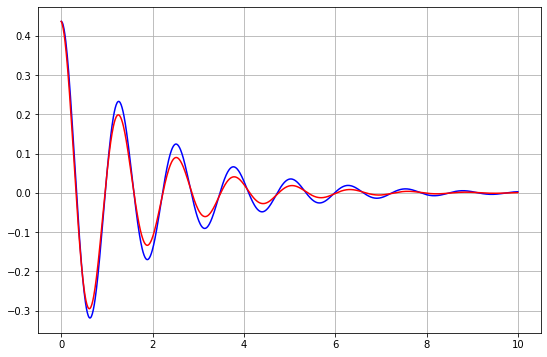

In [14]:
Nt3 = 1000
t3  = np.linspace(t0, tf, Nt3)

Y_heun = pece_ODEsolv(f_1, t0, tf, Nt3, np.array([theta_0, yp0]))
plotear(t2, [decay(t2), Y_heun[:,0]])

Si comparáis la diferencia de tiempos es notable. 

## Métodos Runge Kutta

Los métodos de **Runge-Kutta** son algunos de los más ampliamente utilizados. Vamos a ver aquí algunos ejemplos. Se trata de una familia de métodos que podemos considerar como predictores-correctores. Recordemos que los métodos de Runge-Kutta se definens según el siguiente algoritmo:

$$
y_{n+1} = y_n + h \big( b_1 \phi_1 + ... + b_q \phi_q \big),
$$

donde los $\phi_j$ están deinidos por la expresión

$$
\phi_j = f(t_n + c_j h, \eta_j),
$$
con
$$
\eta_j = y_n + h \big(a_{j,1} \phi_j + ... + a_{j,j-1} \phi_{j-1} \big).
$$

Uno de los métodos más utilizados de esta familia es uno de los métodos **Runge-Kutta 4**. Digo uno de ellos porque hay varios, pero el más común responde al siguiente esquema:

$$
\begin{aligned}
y_{n+1} &= y_n + h \bigg( \dfrac{1}{6} \phi_1 + \dfrac{2}{6} \phi_2 + \dfrac{2}{6} \phi_3 + \dfrac{1}{6} \phi_4 \bigg) \\
\phi_1 &= f\big(t_n, y_n\big) \\
\phi_2 &= f\big(t_{n+1/2}, y_n + \dfrac{h}{2} \phi_1 \big) \\
\phi_3 &= f\big(t_{n+1/2}, y_n + \dfrac{h}{2} \phi_2 \big) \\
\phi_4 &= f\big(t_{n+1}, y_n + h \phi_3 \big)
\end{aligned}
$$

Existen también los métodos de orden 2 y 3. Métodos Runge-Kutta de orden 2 son por ejemplo el método de Heun, o también el llamado método de la poligonal:

- **Método de Heun** (Escrito ahora en forma de método Runge-Kutta):
$$
\begin{aligned}
y_{n+1} &= y_n + h \bigg( \dfrac{1}{2} \phi_1 + \dfrac{1}{2} \phi2 \bigg), \\
\phi_1 &= f\big(t_n, y_n\big) \\
\phi_2 &= f\big(t_{n+1}, y_n + h \phi_1 \big) \\
\end{aligned}
$$
que, por otra parte, puede interpretarse tambien como un método **predictor-corrector**, como vimos en la clase pasada. Aquí os lo dejamos escrito en ese formato:
$$
\left\{
\begin{array}{ll}
p_{n+1} = y_n + h f(t_n, y_n) \\
y_{n+1} = y_n + \dfrac{h}{2} \bigg( f_n + f(t_{n+1}, p_{n+1}) \bigg)
\end{array}
\right.
$$
Vamos, que el mismo método, ecaja a veces en diferentes paradigmas: se trata del mismo método, pero visto desde diferentes ángulos. 

- **Método mejorado de la poligonal**, que también puede interpretarse como un método predictor-corrector:
$$
\begin{aligned}
y_{n+1} &= y_n + h \phi_2, \\
\phi_1 &= f(t_n, y_n), \\
\phi_2 &= f\big(t_{n+1/2}, y_n + \dfrac{h}{2}\phi_1 \big).
\end{aligned}
$$

**¡Ojo!** El método de Heun, lo hemos presentado de tres maneras diferentes: como método implícito, como método de Runge-Kutta, y como método predictor-corrector. Las dos últimas formulaciones son exactamente el mismo algoritmo, y por lo tanto producirán exactamente la misma solución a cualquier problema que se apliquen. Sin embargo, el método Heun implícito es otra cosa. Digamos que las otras dos versiones aproximan el implícito sin llegar a serlo. Éste último es un algoritmo diferente y por lo tanto producirá soluciones numéricas diferentes (aunque parecidas).

### Ejercicio 4

Implementa el método Runge-Kutta 4 como una variante en la función "exp_ODEsolv". Aplícalo a la ecuación de la extinción del balance.

In [15]:
def RK4(f, tn, yn, h):
    phi_1 = f(tn, yn)
    phi_2 = f(tn + 0.5 * h, yn + 0.5 * h * phi_1)
    phi_3 = f(tn + 0.5 * h, yn + 0.5 * h * phi_2)
    phi_4 = f(tn + h, yn + h * phi_3)
    return yn + h / 6. * (phi_1 + 2*phi_2 + 2*phi_3 + phi_4)

def exp_ODEsolv(f, t_0, t_f, N, y0, method="euler"):
    
    # Definimos el paso de malla en función del núero de nodos que nos piden:
    h = (t_f - t_0)/int(N)
    t = np.linspace(t_0, t_f, N)
    Y = np.zeros((N, len(y0))) # Construimos un array para 
    
    # Imponemos la condicion inicial
    Y[0,:] = y0
    
    if method == "euler":
        for n in range(0,N-1):
            Y[n+1,:] = euler(f, t[n], Y[n,:], h)
    elif method == "RK4":
        for n in range(0,N-1):
            Y[n+1,:] = RK4(f, t[n], Y[n,:], h)
            
    else: 
        print("Error ! no conozco el metodo ", method)
        
    return Y

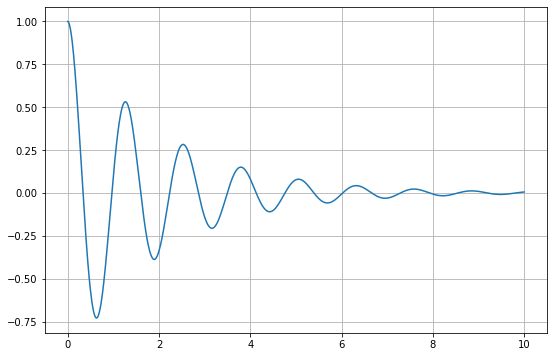

In [16]:
Nt3 = 1000

Y = exp_ODEsolv(f_1, t0, tf, Nt3, np.array([1, 0.]), method="RK4")
plotear(np.linspace(t0, tf, Nt3), Y[:,0])

### Ejercicio 5

Transcribe el método de la poligonal como un método predictor-corrector y escribelo como una variante en la función "pece_ODEsolv"

### Ejercicio 6

Compara ahora los métodos de Euler y Runge-Kutta 4 con la solución exacta. Obtén el orden de convergencia del método Runge-Kutta 4.

### Ejercicio 7

Modifica la función "exp_ODEsolv" para que además de implementar métodos que tenemos ya programados, permita recibir como argumento una función (una función de Python) que defina la actualización de la variable $Y$ mediante un método distinto, de manera que podamos utilizar cualquier métoo que queramos. Utilíza esta nueva capacidad para implementar algún otro método de Runge-Kutta que quieras.